# 7. Working with Keras: A Deep Dive
# 7.2.1. The Sequential Models

## Build a simple 2-layer model

In [1]:
# import library
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
# create model
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

2023-02-17 03:45:20.953625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-17 03:45:20.953678: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


**Note**: The layers are only built (aka init weights) when they are called for the first time, as the shape of the layers' weights depends on the shape of their input. Until the input shape is known, they can't be created.

In [3]:
# if we don't train the model on anything or build it, there will be no weight
# model.weights

In [4]:
# build the model
model.build(input_shape=(None, 4))

In [5]:
# check weight again, it's random as we did not train
model.weights

[<tf.Variable 'dense/kernel:0' shape=(4, 64) dtype=float32, numpy=
 array([[-0.20988956,  0.2547118 , -0.16024497,  0.06808627,  0.2641191 ,
         -0.26319614,  0.29402292, -0.03363341, -0.04103112, -0.00200161,
         -0.04792534, -0.10001785,  0.23360223,  0.19868344,  0.2149347 ,
         -0.16130106,  0.03855383,  0.04265401, -0.07757513, -0.2014072 ,
         -0.11175038,  0.19921678,  0.23305768, -0.23680355,  0.20934176,
          0.14053482, -0.00700581, -0.02600721, -0.04308033,  0.01137376,
          0.2181338 ,  0.04340428,  0.03980139, -0.02305305, -0.10622855,
         -0.2119411 ,  0.03625441, -0.01005188,  0.00549555,  0.2352438 ,
          0.08531776, -0.20846252,  0.18605012, -0.12050377, -0.23076981,
         -0.15062006,  0.1172502 , -0.10980976,  0.03994972,  0.00546014,
         -0.10270727,  0.15632716, -0.25215518, -0.08548412,  0.21119082,
          0.14637017,  0.00224784, -0.01480141, -0.22850448, -0.22900036,
          0.29012513, -0.09597129,  0.2545571

In [6]:
# check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 970
Trainable params: 970
Non-trainable params: 0
_________________________________________________________________


**Note**: You can actually name the model

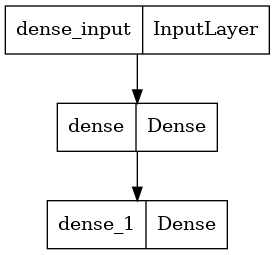

In [7]:
keras.utils.plot_model(model, "simple_classifier.png")

## Build a simple 2-layer model with name initialization

In [8]:
# create a model
model = keras.Sequential(name="minh's model")
model.add(layers.Dense(64, activation="relu", name="first_layer"))
model.add(layers.Dense(10, activation="softmax", name="last_layer"))

# build model (not train on any data)
model.build((None, 3))

# print summary
model.summary()

Model: "minh's model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (Dense)         (None, 64)                256       
                                                                 
 last_layer (Dense)          (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


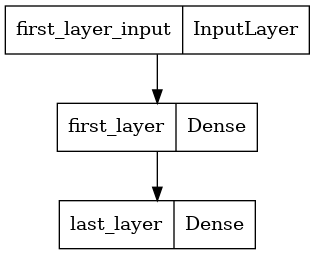

In [9]:
keras.utils.plot_model(model, "simple_classifier.png")

# 7.2.2. The Functional API
- Sequential model is easy to use but its application is extremely limited: it can only express models with a single input and a single output, applying one layer after the other in a sequential fashion. In practice, it's pretty common to encounter model with multiple inputs (image and its metadata), multiple outputs (different things you want to predict at once), or nonlinear topology.


## A. Build a simple Functional model with 3 Dense layers

In [10]:
# init inputs
inputs = keras.Input(shape=(3,), name="my_input")

# binding layers
features_1 = layers.Dense(64, activation="relu")(inputs)
features_2 = layers.Dense(32, activation="relu")(features_1)
outputs = layers.Dense(10, activation="softmax")(features_2)

# connect layers
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,666
Trainable params: 2,666
Non-trainable params: 0
_________________________________________________________________


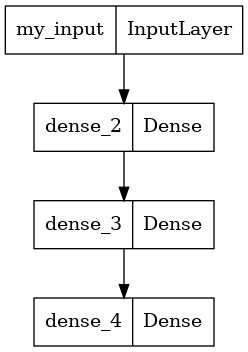

In [12]:
keras.utils.plot_model(model, "simple_classifier.png")

## B. Build a multi-input, multi-output Functional model
- Says, you want to build a system to rank customer support tickers by priority and route them to the appropriate department. Your model has 3 inputs:
    - The title of the ticket (text input).
    - The text body of the ticket (text input).
    - Any tags added by the user (categorical input, assumed here to be one-hot encoded).
- Now, we can encode the text input as arrays of 1s and 0s of size vocabulary_size, so now, your model also has 2 outputs:
    - The priority score of the ticket, a scalar between 0 and 1 (sigmoid output).
    - The department that should handle the ticket (a softmax over the set of department).

### Build a model

In [13]:
vocab_size = 10000
num_tags = 100
num_departments = 4

# define model input
title = keras.Input(shape=(vocab_size,), name="title")
text_body = keras.Input(shape=(vocab_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# define layers
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

# define model output
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# binding model
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

## C. Train a model by providing lists of input and target arrays

In [14]:
num_samples = 1280

# create dummy input data
title_data = np.random.randint(low=0, high=2, size=(num_samples, vocab_size))
text_body_data = np.random.randint(low=0, high=2, size=(num_samples, vocab_size))
tags_data = np.random.randint(low=0, high=2, size=(num_samples, num_tags))

# create dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [15]:
# build model
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"], # loss for regression (priority_data), loss for multi-class classification (department data)
              metrics=[["mean_absolute_error"], ["accuracy"]]) # metrics for regression, classification

# train model on data
model.fit(x=[title_data, text_body_data, tags_data],
          y=[priority_data, department_data],
          epochs=1)

# evaluate model on data
model.evaluate(x=[title_data, text_body_data, tags_data],
               y=[priority_data, department_data])

# predict
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 5ms/step


**Note**: if you don't want to rely on the input order in the case that you got many inputs and outputs. The good thing is that you can activally specify which loss, metrics belong to which data.

In [16]:
vocab_size = 10000
num_tags = 100
num_departments = 4

# define model input
title = keras.Input(shape=(vocab_size,), name="title")
text_body = keras.Input(shape=(vocab_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# define layers
features = layers.Concatenate(name="concatenation_layer")([title, text_body, tags])
features = layers.Dense(64, activation="relu", name="dense_layer")(features)

# define model output
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# binding model
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

In [17]:
# build model
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error",
                    "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_squared_error"],
                       "department": ["accuracy"]})

# train model on data (dictionary ey is based on the input's and output's names)
model.fit(x={"title": title_data,
             "text_body": text_body_data,
             "tags": tags_data},
          y={"priority": priority_data,
             "department": department_data},
          epochs=1)

# evaluate model on data
model.evaluate(x={"title": title_data, "text_body": text_body_data,"tags": tags_data},
               y={"priority": priority_data, "department": department_data})

# make prediction on data
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 5ms/step


**Note**: The functional API is very powerful as it access to layer connectivity. The functional model is an explitcit graph data structure. This makes the model possible to inspect how layers are connect and resue previous graph nodes (layer outputs as part of new model.

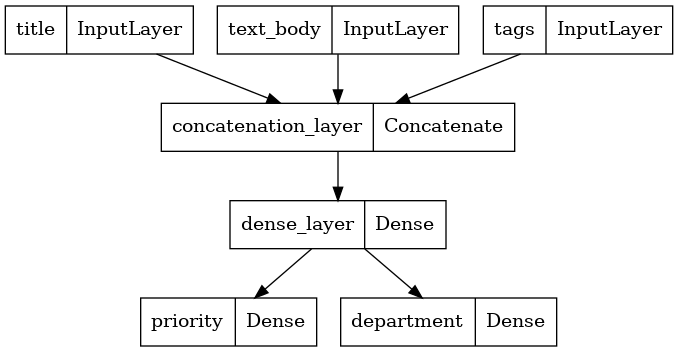

In [18]:
# high level visualization of model
keras.utils.plot_model(model, "my_model.png")

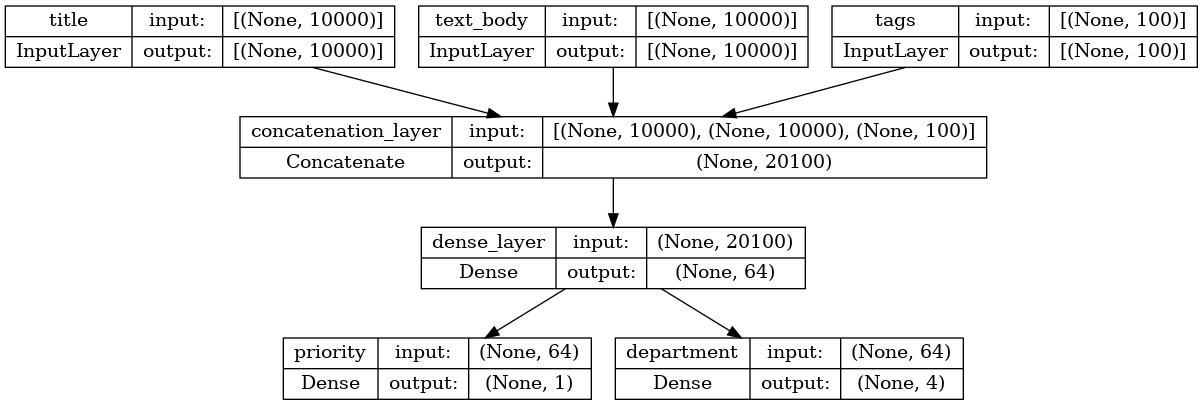

In [19]:
# detailed high level visualization of model
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

**Note**: "None" == batch size. This means that the model allows batches of any size.

### Retrieve the inputs or output of a layer in a Functional model

In [20]:
model.layers

In [21]:
model.layers[3].input # 3 == 3rd table, start from 0

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [22]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenation_layer')>

### Feature Extraction
- As we have access to trained layer, we can create models that reuse intermediate features from another model.
- Says, you want to create another output from previous model, you want to classify "quick", "medium", "difficult" for how long the ticket got to resolve.

In [23]:
# get the output layer of the previous model
features = model.layers[4].output # 4 == 4th table, start from 0
features

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_layer')>

In [24]:
# rewrote the output layer
difficulty = layers.Dense(3, activation="softmax", name= "difficulty")(features) # softmax for multi-class classification (signle label)

# binding model
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department, difficulty])

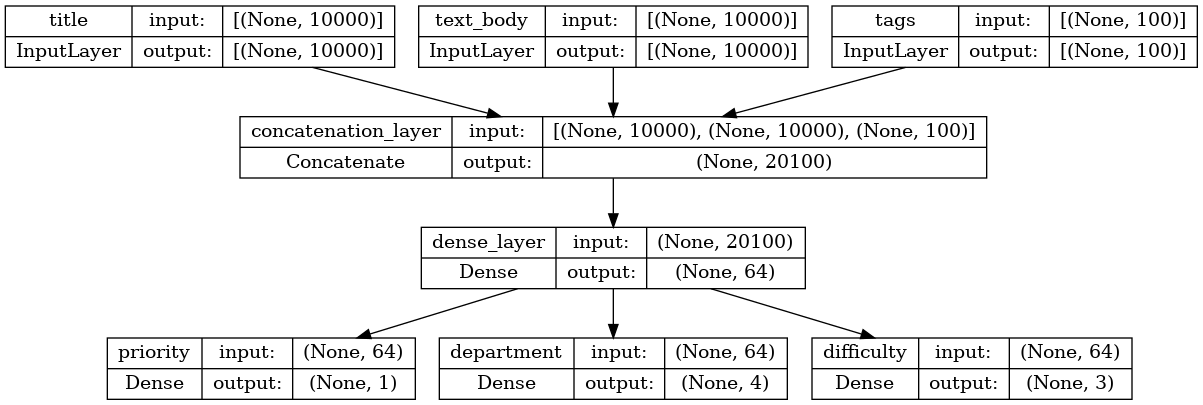

In [25]:
keras.utils.plot_model(model, "updated_ticket_classifier.png", show_shapes=True)

# 7.2.3. Subclassing the Model class
- This model-building pattern is the most advance one, as you have to build everything from scratch.
    - ```__init__()```: define the layers the model will use.
    - ```call()```: define the forward pass of the model, reusing the layers.
    - Instantiate your subclass, and call it on data to create its weights.
- What's the difference between Layer subclass and the Model sub class? 
    - The layer is a building block you use to create models
    - Tthe model is the top level object that you will actually train, export to inference/deployment,...
    - Model has ```fit(), evaluate(), predict()``` methods and Layer don't.
- You can then compile the model similar to how Sequential and Functional model did.
- Why use this methods over Functional API?
    - It enable you to build models that can't be expressed as DAG of layer. If the ```call()``` function has for-loop or recursive call, you can put your logic into it.
    - Acts as blackbox. Very secure.
- Tradeoff? 
    - You can't use ```summary()```
    - You can't use ```plot_model()```
    - You can't do feature extraction.

## Build a multi-input, multi-output Functional model using subclasses model


In [26]:
class CustomerTicketModel(keras.Model):
    
    def __init__(self, num_departments):
        """Constructor"""
        super().__init__()
        
        # define sub layers
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid") # regression
        self.department_classifier = layers.Dense(num_departments, activation="softmax") # multi-class classification
        
    def call(self, inputs):
        """Forward pass"""
        # define input layers
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
        
        # define mixing layers
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        
        # define output layers
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        
        return priority, department

In [27]:
# initialize & build model
model = CustomerTicketModel(num_departments=4)

# fetch input data into model
priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [28]:
# build model
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]]) 

# train model on data (dictionary is based on the input's and output's names)
model.fit(x={"title": title_data,
             "text_body": text_body_data,
             "tags": tags_data},
          y=[priority_data, department_data], epochs=1)

model.evaluate(x={"title": title_data, "text_body": text_body_data, "tags": tags_data},
               y=[priority_data, department_data])

# make prediction on data
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 5ms/step


# 7.2.4. Mixing & Matching Different Components

## Build a Functional model that includes a subclassed model

In [29]:
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        """Constructor"""
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)
        
    def call(self, inputs):
        return self.dense(inputs)

In [30]:
inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

# Build a Sub class model that includes a Functional model

In [31]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

In [32]:
class MyModel(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier
        
    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

In [33]:
model = MyModel()

In [34]:
model